# Notebook d'Exploration

## Mise en place

Librairies et paramétrages utilisés au long du notebook

In [1]:
import datetime as dt
import warnings
import pickle

import numpy as np
import pandas as pd
from pandas import pivot_table
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')

Chargeons des fichiers correspondants à chaque mois de 2016, et concaténons-les en un seul tableau de données

In [3]:
for i in range(1, 13):
    if i == 1:
        data = pd.read_csv('data/2016_01.csv', error_bad_lines=False)
    else:
        n = str(i).zfill(2) if i < 10 else str(i)
        file = pd.read_csv('data/2016_'+n+'.csv', error_bad_lines=False)
        data = pd.concat([data, file], axis=0)

b'Skipping line 121012: expected 65 fields, saw 75\n'
b'Skipping line 386249: expected 65 fields, saw 83\nSkipping line 388291: expected 65 fields, saw 78\nSkipping line 389371: expected 65 fields, saw 72\nSkipping line 389548: expected 65 fields, saw 81\n'
b'Skipping line 453858: expected 65 fields, saw 97\n'


Affichons des informations sommaires sur le jeu de données et ses variables

In [4]:
data.reset_index(drop=True, inplace=True)
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5635978 entries, 0 to 5635977
Data columns (total 65 columns):
YEAR                     5635978 non-null object
QUARTER                  5635978 non-null object
MONTH                    5635978 non-null int64
DAY_OF_MONTH             5635978 non-null object
DAY_OF_WEEK              5635978 non-null object
FL_DATE                  5635978 non-null object
UNIQUE_CARRIER           5635978 non-null object
AIRLINE_ID               5635978 non-null int64
CARRIER                  5635978 non-null object
TAIL_NUM                 5623228 non-null object
FL_NUM                   5635978 non-null object
ORIGIN_AIRPORT_ID        5635978 non-null object
ORIGIN_AIRPORT_SEQ_ID    5635978 non-null int64
ORIGIN_CITY_MARKET_ID    5635978 non-null object
ORIGIN                   5635978 non-null object
ORIGIN_CITY_NAME         5635978 non-null object
ORIGIN_STATE_ABR         5635978 non-null object
ORIGIN_STATE_FIPS        5635978 non-null float64
ORIGIN_

## Sélection des variables

Nous avons choisi de sélectionner les variables suivantes afin d'éviter le data leakage, afin de pouvoir trier les lignes d'observations non-informatives, et en se plaçant du point de vue de l'utilisateur de l'API à venir.

- MONTH
- DAY_OF_MONTH
- DAY_OF_WEEK
- UNIQUE_CARRIER
- ORIGIN
- DEST
- CRS_DEP_TIME
- CRS_ARR_TIME
- CRS_ELAPSED_TIME
- DISTANCE
- CANCELLED
- DIVERTED
- ARR_DELAY

Appliquons cette sous-sélection. Aussi, supprimons les vols déviés ou annulés à l'aide des variables `CANCELLED` et `DIVERTED` qui représentent des cas particuliers qui nuiraient à la généralisation de notre modèle.

In [5]:
selected = data[['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
                 'UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DISTANCE',
                 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME',
                 'CANCELLED', 'DIVERTED', 'ARR_DELAY']]

selected = selected[(selected['CANCELLED']==0) & (selected['DIVERTED']==0)]

selected.drop(['CANCELLED', 'DIVERTED'], axis=1, inplace=True)

Exportons les résultats de ce premier traitement dans un fichier 

In [6]:
selected.to_csv('data/selected.csv')

## Nettoyage

Chargeons la sous-sélection de variables du jeu de données créée précédemment

In [7]:
data = pd.read_csv('data/selected.csv', index_col=[0])
data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,DISTANCE,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,ARR_DELAY
0,1,6,3,AA,DFW,DTW,986.0,1100.0,1438.0,158.0,-6.0
1,1,7,4,AA,DFW,DTW,986.0,1100.0,1438.0,158.0,-12.0
2,1,8,5,AA,DFW,DTW,986.0,1100.0,1438.0,158.0,7.0
3,1,9,6,AA,DFW,DTW,986.0,1100.0,1438.0,158.0,-5.0
4,1,10,7,AA,DFW,DTW,986.0,1100.0,1438.0,158.0,113.0


Vérifions le nombre de valeurs manquantes par variable

In [8]:
data.isnull().sum()

MONTH               0
DAY_OF_MONTH        0
DAY_OF_WEEK         0
UNIQUE_CARRIER      0
ORIGIN              0
DEST                0
DISTANCE            0
CRS_DEP_TIME        0
CRS_ARR_TIME        0
CRS_ELAPSED_TIME    0
ARR_DELAY           0
dtype: int64

In [9]:
data.rename(columns={'UNIQUE_CARRIER': 'CARRIER', 'CRS_DEP_TIME': 'DEP_TIME', 'CRS_ARR_TIME': 'ARR_TIME', 
                     'CRS_ELAPSED_TIME': 'ELAPSED_TIME', 'ARR_DELAY': 'DELAY'}, inplace=True)

### Traitement selon la variable cible

Observons graphiquement la distribution de notre variable cible à l'aide d'un boxplot

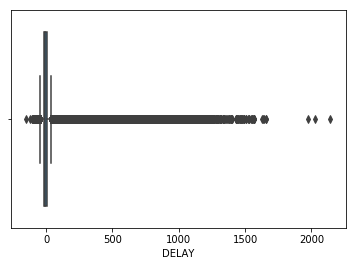

In [10]:
sns.boxplot(data['DELAY']);

Il existe des valeurs si extrêmes que la "boite" du graphe se retrouve "écrasée". Observons numériquement cette distribution avec des statistiques sommaires et quartiles bien choisis, qui nous permettent de bien détailler les valeurs extrêmes positives, qui sont celles qui sont suceptibles de nous poser problème d'après l'interprétation qu'on peut faire de notre graphe précédent.

In [11]:
data['DELAY'].describe([0.1, 0.5, 0.9, 0.95, 0.975])

count    5.556195e+06
mean     3.536409e+00
std      4.192246e+01
min     -1.520000e+02
10%     -2.100000e+01
50%     -6.000000e+00
90%      3.200000e+01
95%      6.500000e+01
97.5%    1.080000e+02
max      2.142000e+03
Name: DELAY, dtype: float64

Nous choisissons de ne garder que des observations dont la valeur cible se trouve à peu près entre 40 minutes d'avance et 40 minutes de retard, respectivement au dessus du 1e rang centile et au 91e rang centile de la distribution initiale. Ce choix est fait afin de supprimer les valeurs extrêmes observées précédemment, et donc ne prendre en compte que les cas les plus courants et vraisemblables dans notre modélisation.

In [12]:
LOW = -40
HIGH = 40
mask = data['DELAY'].between(LOW, HIGH)

print('Rang-centile de {} minutes: {}'.format(LOW, stats.percentileofscore(data['DELAY'], LOW)))
print('Rang-centile de {} minutes: {}'.format(HIGH, stats.percentileofscore(data['DELAY'], HIGH)))

Rang-centile de -40 minutes: 0.4603330156698964
Rang-centile de 40 minutes: 91.66122679279614


Comparons la distribution résultante à celle des données brutes en affichant de nouveau un boxplot

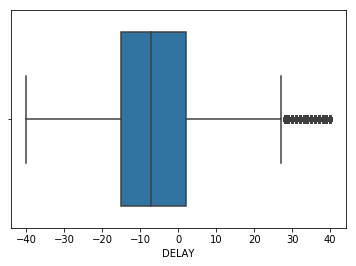

In [13]:
sns.boxplot(data.loc[mask, 'DELAY']);

Nous obtenons ainsi une variable cible dont la distribution est proche d'une loi log-normale

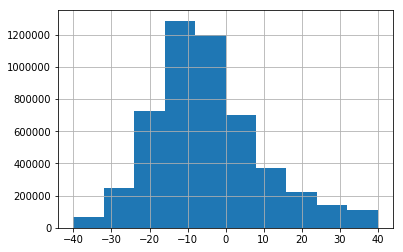

In [14]:
data.loc[mask, 'DELAY'].hist();

Appliquons le filtrage effectué au jeu de données, en supprimant les observations considérées comme *outliers*

In [15]:
data = data[mask]
print("Nous supprimons {}% des lignes.".format(round((mask.size - mask.sum())/mask.size*100)))

Nous supprimons 9.0% des lignes.


### Feature engineering

Les attributs `DEP_TIME` et `ARR_TIME` nous ont été donnés sous la forme HHMM. Nous ne souhaitons pas conserver autant de précision, et décidons de ne garder que les heures de départ et d'arrivée

In [16]:
for column in ['DEP_TIME', 'ARR_TIME']:
    data[column] = data[column].values.astype(int).astype('str')
    data[column] = data[column].str.zfill(4).str[:2].astype(int)

Selon une idée venant de [Hortonworks](https://hortonworks.com/blog/data-science-apacheh-hadoop-predicting-airline-delays/) ayant travaillé sur un projet similaire avec Hadoop, on ajoute un attribut qui pour chaque instance indique le nombre de jour qui la sépare du jour férié le plus proche. Pour cela nous retenons les 10 jours fériés les plus important au niveau fédéral aux États-Unis:

- *New Year's Day*
- *Martin Luther King Jr. Day*
- *President's Day*
- *Memorial Day*
- *Independance Day*
- *Labor Day*
- *Columbus Day*
- *Veteran's Day*
- *Thanksgiving Day* 
- *Christmas Day*

Calculons pour chaque jour de l'année 2016 (année de notre jeu de données), le nombre de jour minimal qui le sépare d'un jour férié

In [17]:
holidays = np.array(['2016-01-01', '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25'],
                    dtype='datetime64[D]')
dates_2016 = pd.date_range('2016-01-01', '2016-12-31', freq='D').to_datetime().values.astype('datetime64[D]')

deltas_2016 = []
for date in dates_2016:
    delta = np.min(np.abs(holidays - date))
    deltas_2016.append(delta.astype(int))

Utilisons cette liste pour assigner à chaque observation dans notre jeu de donné un nouvel attribut: le nombre de jour qui le sépare du jour férié le plus proche (antérieurement et postérieurement)

In [18]:
def to_holidays(row):
    index = (dt.date(2016, row['MONTH'], row['DAY_OF_MONTH']) - dt.date(2016, 1, 1)).days
    return deltas_2016[index]

data['TO_HOLIDAYS'] = data.apply(to_holidays, axis=1)

Affichons les premières lignes de notre nouvelle dataframe

In [19]:
data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CARRIER,ORIGIN,DEST,DISTANCE,DEP_TIME,ARR_TIME,ELAPSED_TIME,DELAY,TO_HOLIDAYS
0,1,6,3,AA,DFW,DTW,986.0,11,14,158.0,-6.0,5
1,1,7,4,AA,DFW,DTW,986.0,11,14,158.0,-12.0,6
2,1,8,5,AA,DFW,DTW,986.0,11,14,158.0,7.0,7
3,1,9,6,AA,DFW,DTW,986.0,11,14,158.0,-5.0,8
5,1,11,1,AA,DFW,DTW,986.0,11,14,158.0,-3.0,7


## Sauvegardes

Enfin, exportons nos données nettoyées prêtes pour les phases d'exploration et de modélisation

In [20]:
data.to_csv('data/final_data.csv')

Aussi, récupérons certaines informations qui seront utiles à la conception de l'api de l'API: …

… les compagnies aériennes

In [21]:
carriers_abr = data['CARRIER'].unique().tolist()
carriers_names = ['American Airlines', 'Alaskan Airlines', 'JetBlue', 'Delta Air Lines', 'Frontier Airlines', 'Hawaiian Airlines', 'Spirt Airlines', 
                  'ExpressJet', 'Skywest', 'United Airlines', 'Virgin America', 'Southwest Airlines' ]
CARRIERS = list(zip(carriers_abr, carriers_names))

… les différents aéroports

In [22]:
ori = sorted(data['ORIGIN'].unique().tolist())
des = sorted(data['DEST'].unique().tolist())

ORI = list(zip(ori, ori))
DES = list(zip(des, des))

… les distances entre aéroports

In [23]:
paths = data[['ORIGIN', 'DEST', 'DISTANCE']].drop_duplicates()
paths['TRIP'] = paths.apply(lambda row: row['ORIGIN']+'-'+row['DEST'], axis=1)

DISTANCES = (paths.set_index('TRIP')
             .drop(['ORIGIN', 'DEST'], axis=1)
             .to_dict()
             .get('DISTANCE'))

Et sauvegardons-les

In [24]:
with open('api_infos.pkl', 'wb') as f:
    pickle.dump([CARRIERS, ORI, DES], f)
with open('distances.pkl', 'wb') as f:
    pickle.dump(DISTANCES, f)

## Exploration des données

### Exploration univariée

Pour des variables catégorielles choisies - `MONTH`, `DAY_OF_WEEK`, `DEP_TIME`, `ARR_TIME` - observons la moyenne de la variable cible par modalité. Observations intéressantes: il semble qu'en moyenne, avec les données gardées, les avions aient tendance à arriver en avance.

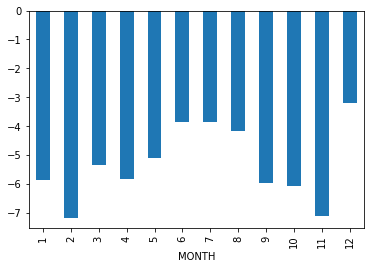

In [25]:
data.groupby('MONTH')['DELAY'].mean().plot(kind='bar');

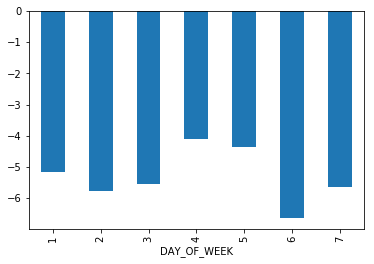

In [26]:
data.groupby('DAY_OF_WEEK')['DELAY'].mean().plot(kind='bar');

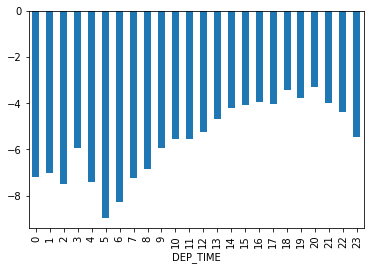

In [27]:
data.groupby('DEP_TIME')['DELAY'].mean().plot(kind='bar');

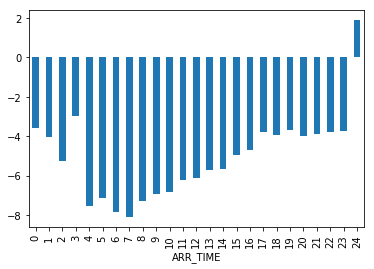

In [28]:
data.groupby('ARR_TIME')['DELAY'].mean().plot(kind='bar');

Bien que pour certaines variables, telles que que `DAY_OF_WEEK`, nous pouvons observer des  

### Exploration multivariée

Prise en charge des vols par compagnie aérienne sur l'ensemble de l'année

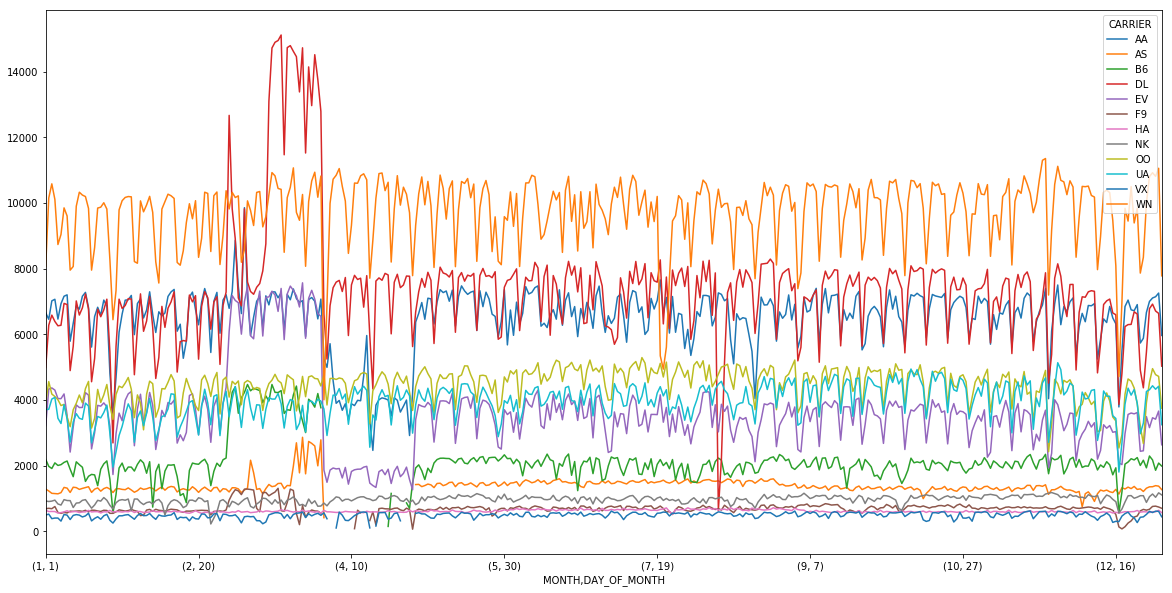

In [29]:
table = pivot_table(data[['MONTH', 'DAY_OF_MONTH', 'CARRIER']], 
                    values=None, index=['MONTH', 'DAY_OF_MONTH'], columns=['CARRIER'], aggfunc=np.count_nonzero)
table.plot(figsize=(20, 10));

Retard moyen observé sur chaque jour de l'année, toutes compagnies confondues. Nous y ajoutons des axes verticaux marquant chaque jour férié de l'année.

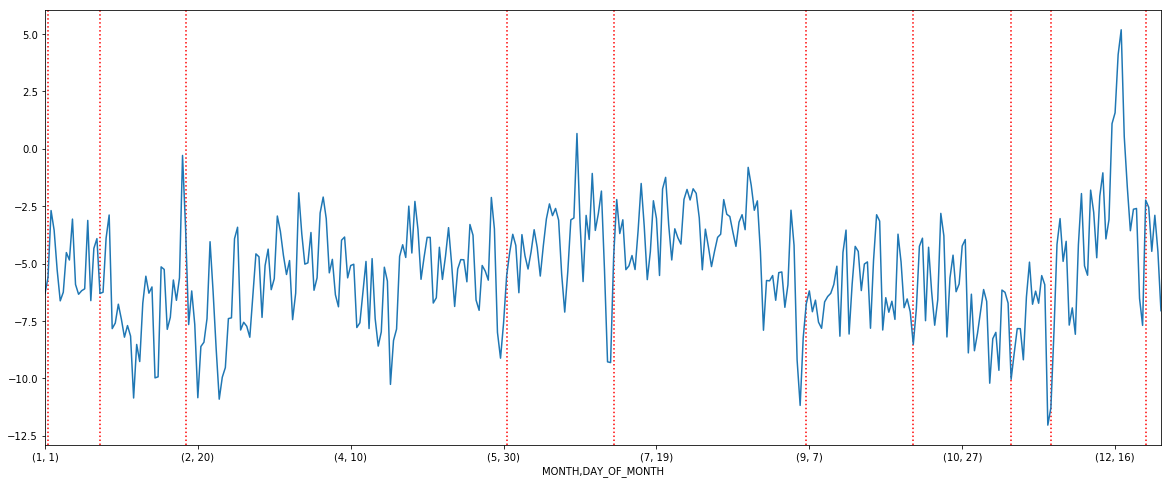

In [30]:
ax = (data.sort_values(by=['MONTH', 'DAY_OF_MONTH'], axis=0)
      .groupby(['MONTH', 'DAY_OF_MONTH'])['DELAY'].mean()
      .plot(figsize=(20, 8))
     )

ymin, ymax = ax.get_ylim()
ax.set_ylim([ymin,ymax])

holidays = np.array(['2016-01-01', '2016-01-18', '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-25'],
                    dtype='datetime64[D]')
dates = [date.timetuple().tm_yday for date in holidays.tolist()]
ax.vlines(x=dates, ymin=ymin, ymax=ymax, color='r', linestyles='dotted');

### Correlations avec la variable cible

Scatter plot entre variables explicatives numériques et variable cible. Calcul du coefficient de correlation de Pearson

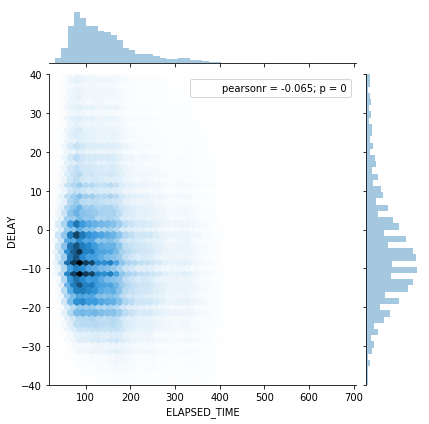

In [31]:
sns.jointplot(x='ELAPSED_TIME', y='DELAY', data=data, kind='hex');

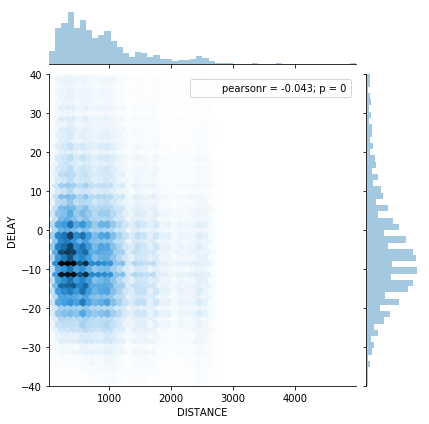

In [32]:
sns.jointplot(x='DISTANCE', y='DELAY', data=data, kind='hex');

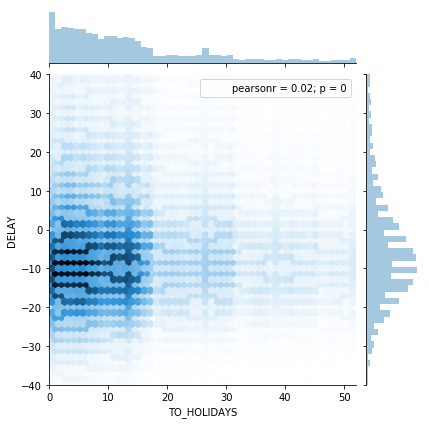

In [33]:
sns.jointplot(x='TO_HOLIDAYS', y='DELAY', data=data, kind='hex');